In this notebook I want to explore, given 2 2D polyhedrons, how can I find out what all the possible contact modes there are between them and the corresponding contact locations, constraints, whether contact or no contact

In [1]:
from dataclasses import dataclass
from enum import Enum
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.convex_set import ConvexSet
import numpy as np
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
import matplotlib.pyplot as plt
import itertools
from large_gcs.geometry.geometry_utils import *


In [2]:
np.degrees(counter_clockwise_angle_between(np.array([0, -1]), np.array([-0.0001, 1])))

-179.99427042206779

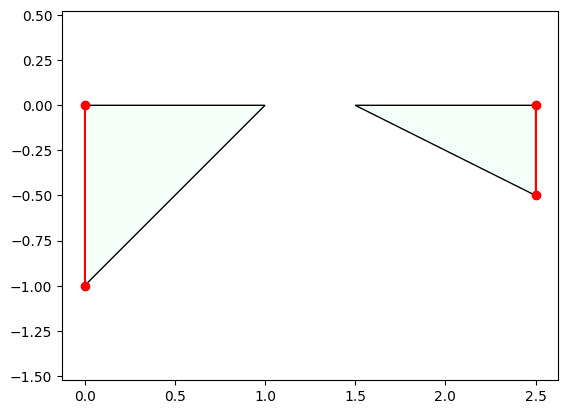

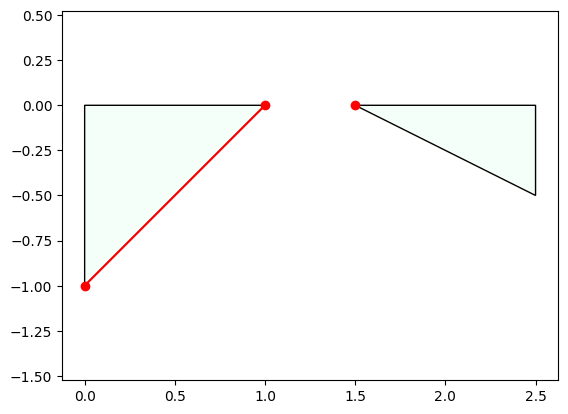

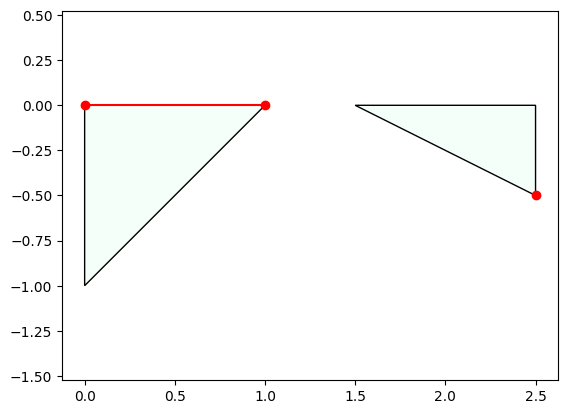

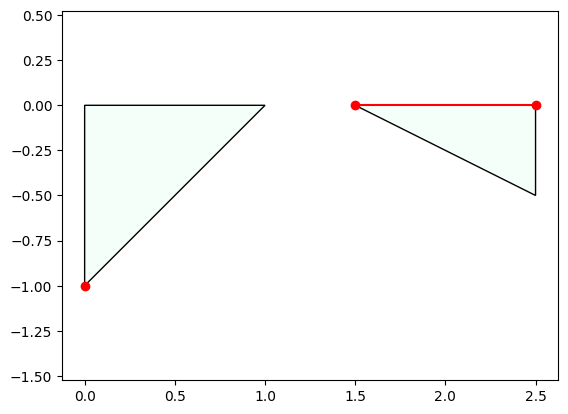

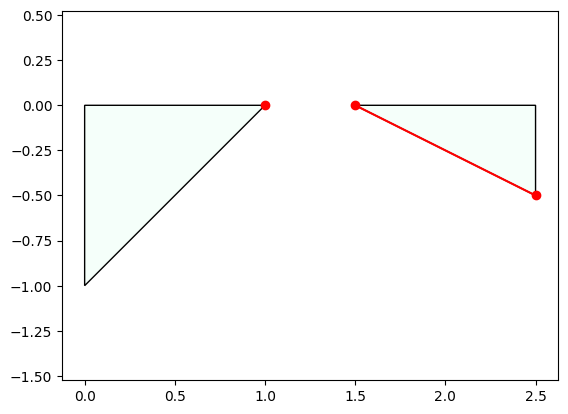

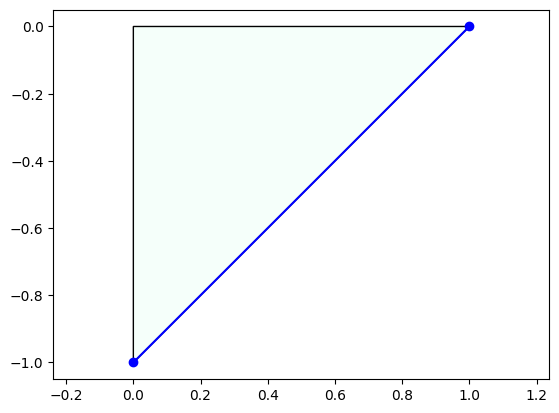

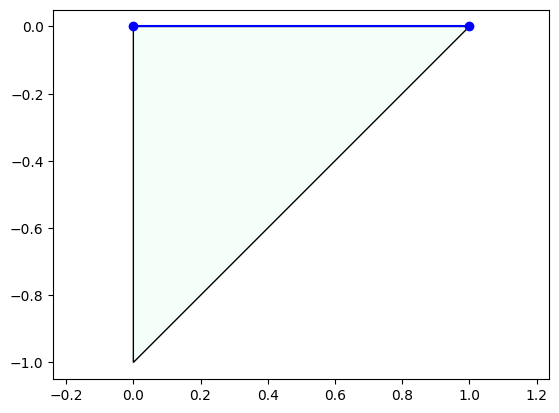

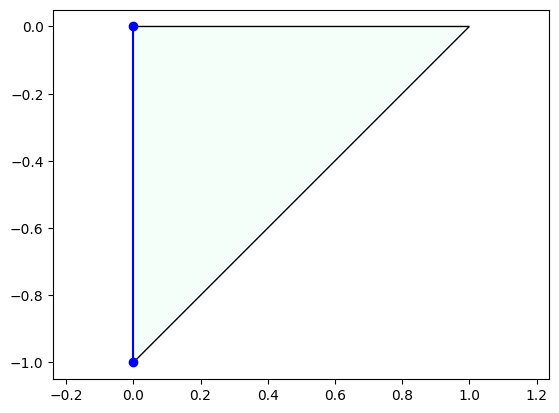

In [18]:
class MobilityType(Enum):
    STATIC = 1
    UNACTUATED = 2
    ACTUATED = 3

@dataclass
class RigidBody:
    name: str
    geometry: Polyhedron # For now, only allow convex sets, and specifically polyhedra
    mobility_type: MobilityType

    @property
    def dimension(self):
        return self.geometry.dimension
    
    @property
    def n_vertices(self):
        return len(self.geometry.vertices)
    
    @property
    def n_faces(self):
        return len(self.geometry.set.b())

@dataclass
class ContactLocation():
    body: RigidBody

    def plot(self, **kwargs):
        if self.body.dimension != 2:
            raise NotImplementedError
        self.body.geometry.plot()
        options = {"color": "r", "zorder": 2}
        options.update(kwargs)
        self._plot(**options)


@dataclass
class ContactLocationVertex(ContactLocation):
    index: int
    
    def _plot(self, **kwargs):
        self.body.geometry.plot_vertex(self.index, **kwargs)

    @property
    def vertex(self):
        return self.body.geometry.vertices[self.index]
    
    @property
    def adj_faces(self):
        if self.body.dimension != 2: raise NotImplementedError
        adj_face_before = ContactLocationFace(self.body, (self.index - 1) % self.body.n_vertices)
        adj_face_after = ContactLocationFace(self.body, self.index)
        return (adj_face_before, adj_face_after)
    

@dataclass
class ContactLocationFace(ContactLocation):
    halfspace_index: int

    def _plot(self, **kwargs):
        self.body.geometry.plot_vertex(self.adj_vertex_indices[0], **kwargs)
        self.body.geometry.plot_vertex(self.adj_vertex_indices[1], **kwargs)
        self.body.geometry.plot_face(self.halfspace_index, **kwargs)

    @property
    def normal(self):
        return self.body.geometry.set.A()[self.halfspace_index]
    
    @property
    def b(self):
        return self.body.geometry.set.b()[self.halfspace_index]
    
    @property
    def unit_normal(self):
        return self.normal / np.linalg.norm(self.normal)
    
    @property
    def adj_vertex_indices(self):
        if self.body.dimension != 2: raise NotImplementedError
        return np.array([self.halfspace_index, (self.halfspace_index + 1) % self.body.geometry.vertices.shape[0]])
    

@dataclass
class ContactPairMode():
    """Contact mode between two contact locations on two rigid bodies"""
    body_a: RigidBody
    body_b: RigidBody    

@dataclass
class InContactPairMode(ContactPairMode):
    contact_location_a: ContactLocation
    contact_location_b: ContactLocation

    def plot(self, **kwargs):
        fig = plt.figure()
        self.contact_location_a.plot(**kwargs)
        self.contact_location_b.plot(**kwargs)
        plt.show()

@dataclass
class NoContactPairMode(ContactPairMode):
    face_a: ContactLocationFace

    def plot(self, **kwargs):
        fig = plt.figure()
        self.face_a.plot(color = "blue", **kwargs)
        plt.show()

obj_vertices = np.array([[0, 0], [1, 0], [1, -0.5]]) + np.array([1.5,0])
# obj_vertices = np.array([[0, 0], [1, 0.2], [0.7, -0.5]]) + np.array([1.5,0])
# obj_vertices = np.array([[0, 0], [1, 0], [1, 1], [0,1]]) + np.array([1.5,0])
obs = RigidBody(name="obstacle", geometry=Polyhedron.from_vertices([[0, 0], [1, 0], [0, -1]]), mobility_type=MobilityType.STATIC)
obj = RigidBody(name="object", geometry=Polyhedron.from_vertices(obj_vertices), mobility_type=MobilityType.ACTUATED)
# obs.geometry.plot()
# obj.geometry.plot()

def is_possible_face_face_contact(face_a: ContactLocationFace, face_b: ContactLocationFace):
    """Check if two faces can be in contact"""
    return np.isclose(np.dot(face_a.unit_normal, face_b.unit_normal), -1)

def is_possible_face_vertex_contact(face: ContactLocationFace, vertex: ContactLocationVertex):
    """Check if a face and a vertex can be in contact"""
    adj_face_before, adj_face_after = vertex.adj_faces

    before_angle = counter_clockwise_angle_between(face.unit_normal, adj_face_before.unit_normal)
    after_angle = counter_clockwise_angle_between(face.unit_normal, adj_face_after.unit_normal)

    # If the faces are parallel or anti-parallel, then the vertex is not in contact
    if (np.isclose(before_angle, np.pi) or
        np.isclose(after_angle, np.pi) or
        np.isclose(before_angle, -np.pi) or
        np.isclose(after_angle, -np.pi) or
        np.isclose(before_angle, 0) or
        np.isclose(after_angle, 0)):
        res = False
    # If the above is not true, 
    # AND the angle between the face normal and adjacent face to the "right"
    # (where the adjacent normals are pointing up, and the vertex is in between them)
    # AKA "before" (in a counter clockwise sense) 's normal has a negative angle
    # AND the angle between the face normal and adjacent face to the "left"
    # AKA "after" (in a counter clockwise sense) 's normal has a positive angle
    elif after_angle < 0 and before_angle > 0:
        res = True
    else:
        res = False
    return res

def generate_contact_pair_modes(body_a: RigidBody, body_b: RigidBody):
    """Generate all possible contact pair modes between two rigid bodies"""
    contact_pair_modes = []

    # Face-face contact
    for index_a, index_b in itertools.product(range(body_a.n_faces), range(body_b.n_faces)):        
        # Check if normals are in opposite directions
        face_a = ContactLocationFace(body=body_a, halfspace_index=index_a)
        face_b = ContactLocationFace(body=body_b, halfspace_index=index_b)
        if is_possible_face_face_contact(face_a, face_b):
            contact_pair_modes.append(
                InContactPairMode(body_a=body_a, body_b=body_b,
                                  contact_location_a=face_a,
                                  contact_location_b=face_b))

    # Face-vertex contact
    for index_a, index_b in itertools.product(range(body_a.n_faces), range(body_b.n_vertices)):
        face_a = ContactLocationFace(body=body_a, halfspace_index=index_a)
        vertex_b = ContactLocationVertex(body=body_b, index=index_b)
        if is_possible_face_vertex_contact(face_a, vertex_b):
            contact_pair_modes.append(
                InContactPairMode(body_a=body_a, body_b=body_b,
                                  contact_location_a=face_a,
                                  contact_location_b=vertex_b))
            
    # Vertex-face contact
    for index_a, index_b in itertools.product(range(body_a.n_vertices), range(body_b.n_faces)):
        vertex_a = ContactLocationVertex(body=body_a, index=index_a)
        face_b = ContactLocationFace(body=body_b, halfspace_index=index_b)
        if is_possible_face_vertex_contact(face_b, vertex_a):
            contact_pair_modes.append(
                InContactPairMode(body_a=body_a, body_b=body_b,
                                  contact_location_a=vertex_a,
                                  contact_location_b=face_b))
            
    # No contact relative to body_a
    for index_a in range(body_a.n_faces):
        face_a = ContactLocationFace(body=body_a, halfspace_index=index_a)
        contact_pair_modes.append(
            NoContactPairMode(body_a=body_a, body_b=body_b,
                              face_a=face_a))
    return contact_pair_modes

contact_pair_modes = generate_contact_pair_modes(obs, obj)
for contact_pair_mode in contact_pair_modes:
    contact_pair_mode.plot()



In [19]:
len(contact_pair_modes)

8

Testing individual functionality

In [4]:
obj = RigidBody(name="object", geometry=Polyhedron.from_vertices([[0, 0], [1, 0], [1, -0.5]]), mobility_type=MobilityType.ACTUATED)
# obj.geometry.plot(mark_center=True)
# print("vertices", obj.geometry.vertices)
# print("A", obj.geometry.set.A())
# print("b", obj.geometry.set.b())
# obj.geometry.plot_face(0, color="r")
# obj.geometry.plot_halfspace(2, color="blue", alpha=0.5, linestyle="-.")

# v = ContactLocationVertex(body=obj, index=2)
# v.plot()
# e = ContactLocationEdge(body=obj, halfspace_index=0)
# e.adj_vertex_indices